In [1]:
from Binaries import *

In [9]:
def do_t3_simulation(self, dataset, n_points = 1e5):

    if isinstance(n_points, float): n_points = int(n_points)

    fitparams = np.loadtxt(f"/cr/data01/filip/models/{self.name}/ROC_curve/{dataset}/fit_params.csv")
    plt.rcParams["figure.figsize"] = [25, 18]
    plt.rcParams["font.size"] = 22
    colormap = cmap.get_cmap("plasma")
    fig, ax = plt.subplots()

    # set up plot
    ax.text( 635, -55, "T3 detected", fontsize = 22)
    ax.text(1395, 775, "T3 missed", fontsize = 22)
    symmetry_line = lambda x : 1500 - x
    X = np.linspace(700, 1550, 100)
    ax.scatter([0, 1500, 750, 2250], [0, 0, 750, 750], s = 100, c = "k")
    ax.plot(X, symmetry_line(X), ls = "solid", c = "k", zorder = 0, lw = 2)
    ax.add_patch(Polygon([[0,0], [1500, 0], [750, 750]], closed = True, color = "green", alpha = 0.1, lw = 0))
    ax.add_patch(Polygon([[750, 750], [1500, 0], [2250, 750]], closed = True, color = "red", alpha = 0.1, lw = 0))

    # create shower cores in target area
    theta_bins = [0, 26, 38, 49, 60, 90]
    ys = np.random.uniform(0, 750, n_points)
    xs = np.random.uniform(0, 1500, n_points) + ys
    reflect = [ ys[i] > symmetry_line(xs[i]) for i in range(len(xs))]
    xs[reflect] = -xs[reflect] + 2250
    ys[reflect] = -ys[reflect] + 750

    # do the T3 simulation
    t3_hits, t3_misses = np.zeros((7, 5)), np.zeros((7, 5))
    x_container, y_container = [[[] for t in range(5)] for e in range(7)], [[[] for t in range(5)] for e in range(7)]
    stations = [[0, 0, 0], [1500, 0, 0], [750, 750, 0]]

    for step_count, (x, y) in enumerate(zip(xs, ys)):

        print(f"Enumerating showers: {step_count + 1}/{len(xs)} ~ {(step_count + 1)/len(xs) * 1e2:.2f}%", end = "\r")

        energy_and_theta = np.random.randint(0, len(fitparams))
        energy, t = energy_and_theta // 5, energy_and_theta % 5
        fit_function = lambda spd : station_hit_probability(x, *fitparams[energy_and_theta])

        # choose theta, phi at random, calculate shower_plane_distance
        theta = np.radians(np.random.uniform(theta_bins[t], theta_bins[t + 1]))
        phi = np.random.uniform(0, 2 * np.pi)
        sp_distances = []
        
        for station in stations:

            core_position = np.array([x, y, 0])
            core_origin = np.sin(theta) * np.array([np.cos(phi), np.sin(phi), 1/np.tan(theta)]) + core_position

            shower_axis = core_position - core_origin
            dot_norm = np.dot(shower_axis, shower_axis)
            perpendicular_norm = np.dot(station - core_origin, shower_axis) / dot_norm
            sp_distances.append( np.linalg.norm(perpendicular_norm * shower_axis + (core_origin - station)))

        # #  In case of paranoia regarding distance calculation break comment
        # ax.add_patch(plt.Circle((0, 0), sp_distances[0], color='b', fill=False))
        # ax.add_patch(plt.Circle((1500, 0), sp_distances[1], color='b', fill=False))
        # ax.add_patch(plt.Circle((750, 750), sp_distances[2], color='b', fill=False))

        trigger_probabilities = [fit_function(distance) for distance in sp_distances]
        dice_roll = np.random.uniform(0, 1, 3)

        if np.all(dice_roll < trigger_probabilities):
            t3_hits[energy][t] += 1
            # plt.scatter(x, y, c = "k")
        else:
            x, y = 2250 - x, 750 - y
            t3_misses[energy][t] += 1
            # plt.scatter(x, y, c = "r")

        x_container[energy][t].append(x)
        y_container[energy][t].append(y)

    size_bins = [30, 50, 70, 90, 110, 160, 200]
    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]

    for e, (x_energy, y_energy) in enumerate(zip(x_container, y_container)):
        for t, (x, y) in enumerate(zip(x_energy, y_energy)):

            c = colormap(t / len(x_energy))
            s = size_bins[e]

            ax.scatter(x[::100], y[::100], color = c, s = s, marker = "x")

    for e, bin in enumerate(size_bins):
        ax.scatter([],[], c = "k", s = bin, label = e_labels[e] + r" $\leq$ log($E$ / eV) < " + e_labels[e + 1], marker = "x")

    ax.set_aspect('equal')
    # ax.legend(fontsize = 18)
    plt.xlabel("Easting / m")
    plt.ylabel("Northing / m")

    norm = BoundaryNorm(theta_bins, colormap.N)
    ax2 = fig.add_axes([0.91, 0.3, 0.01, 0.4])
    ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"Zenith angle")

    plt.figure()

    e_labels = EventGenerator.libraries.keys()
    t_labels = ["0_26", "26_38", "38_49", "49_60", "60_90"]

    sns.heatmap(t3_hits / (t3_hits + t3_misses) * 1e2, annot = True, fmt = ".1f", cbar_kws = {"label" : "T3 efficiency / %"})
    plt.xticks(ticks = 0.5 + np.arange(0, 5, 1), labels = t_labels)
    plt.yticks(ticks = 0.5 + np.arange(0, 7, 1), labels = e_labels)
    plt.xlabel("Zenith range")
    plt.ylabel("Energy range")

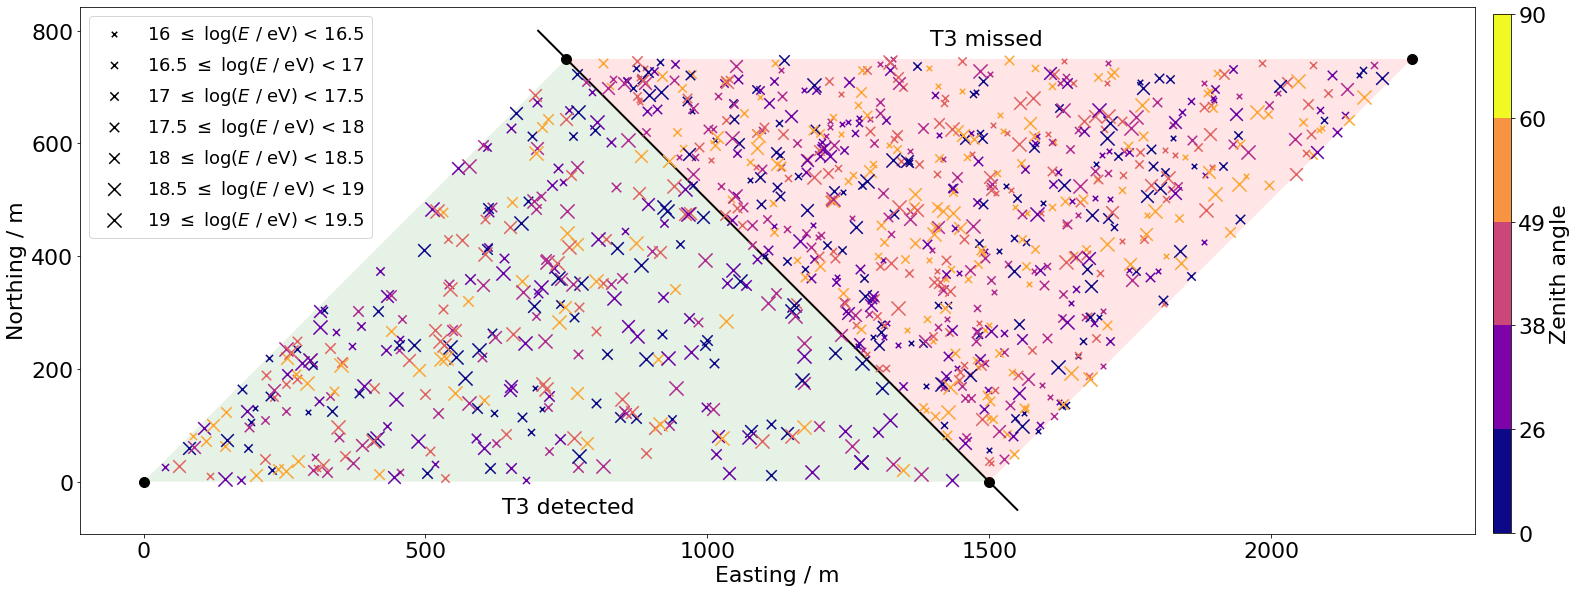

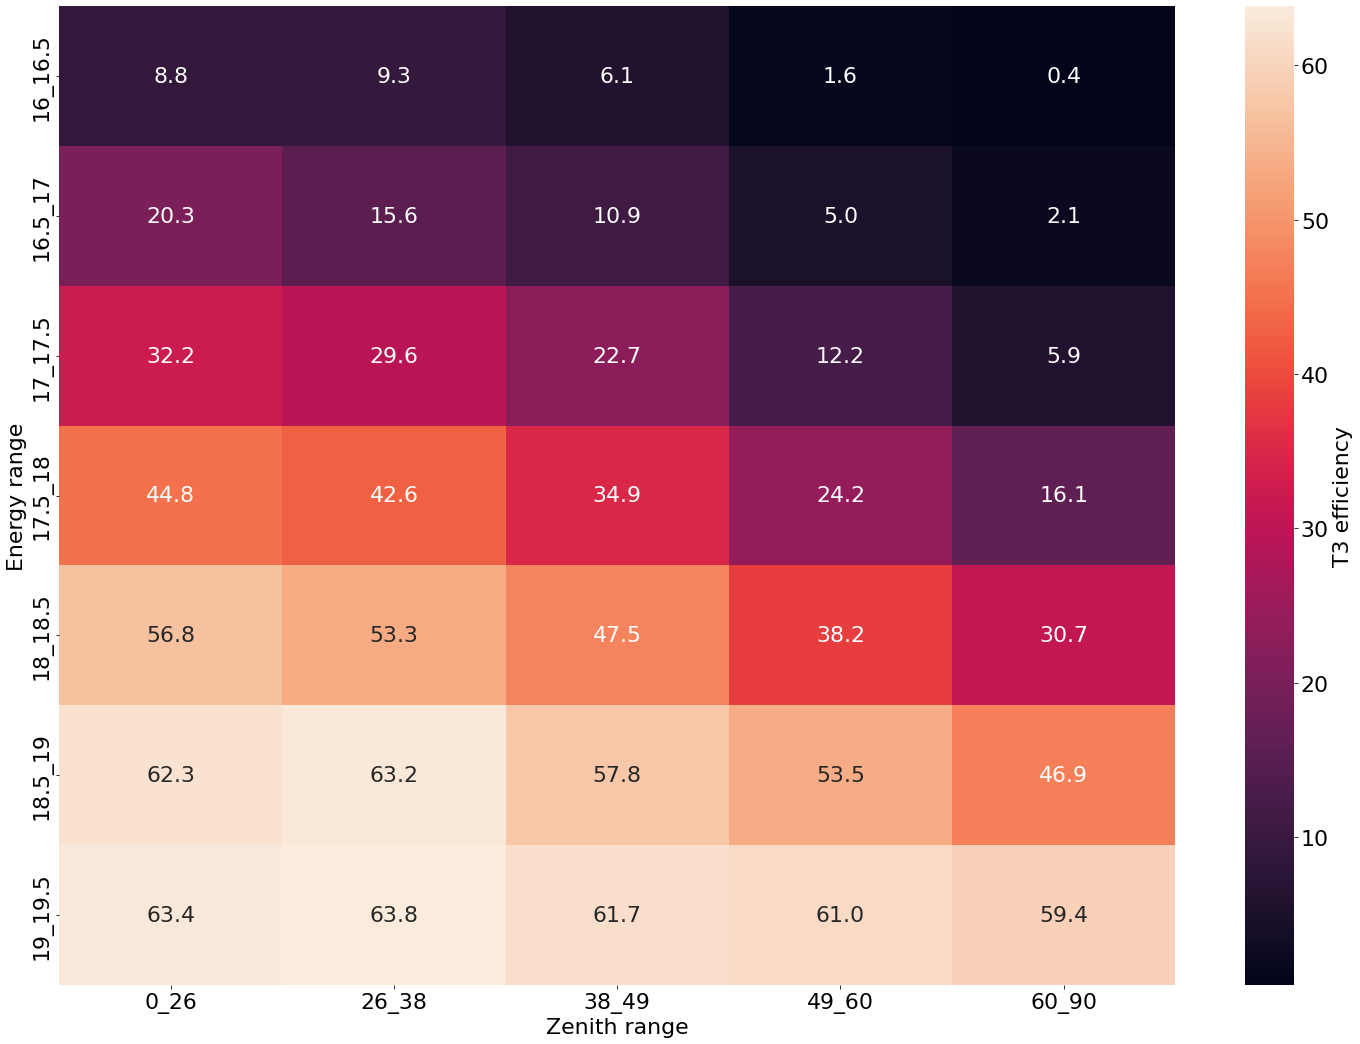

In [20]:
do_t3_simulation(1e5)

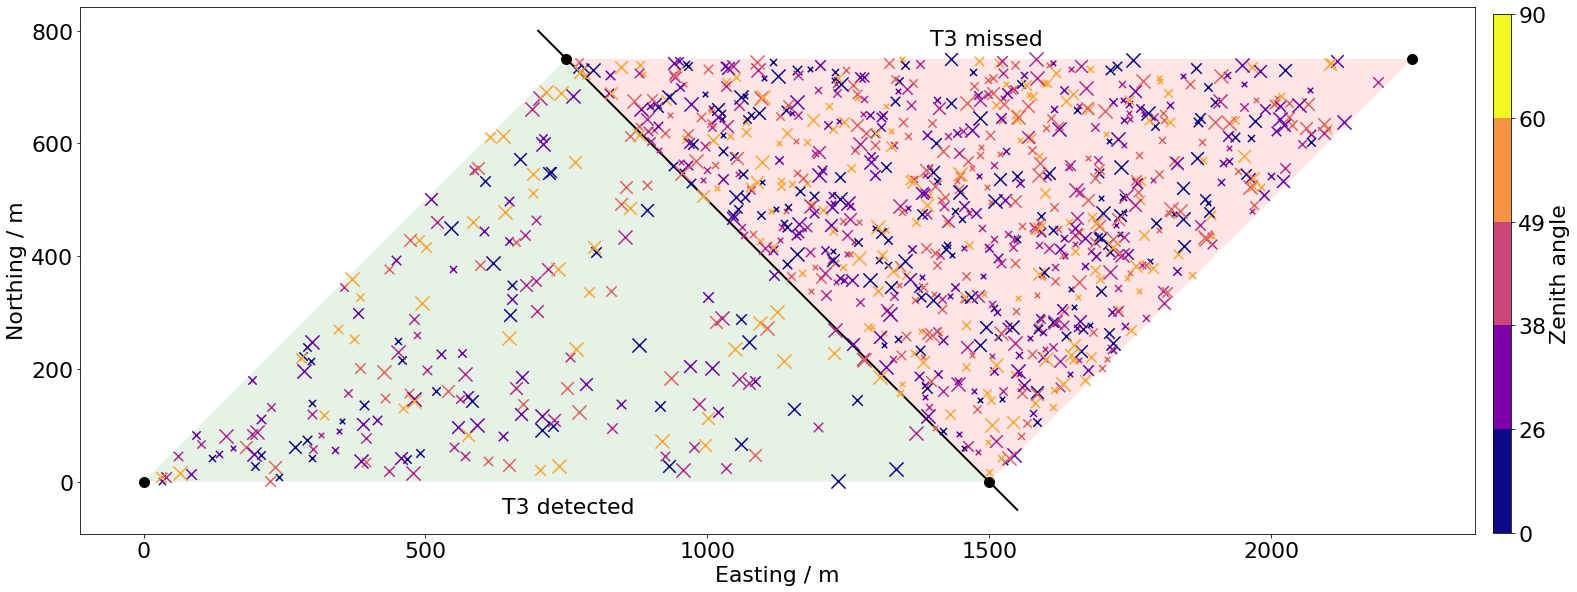

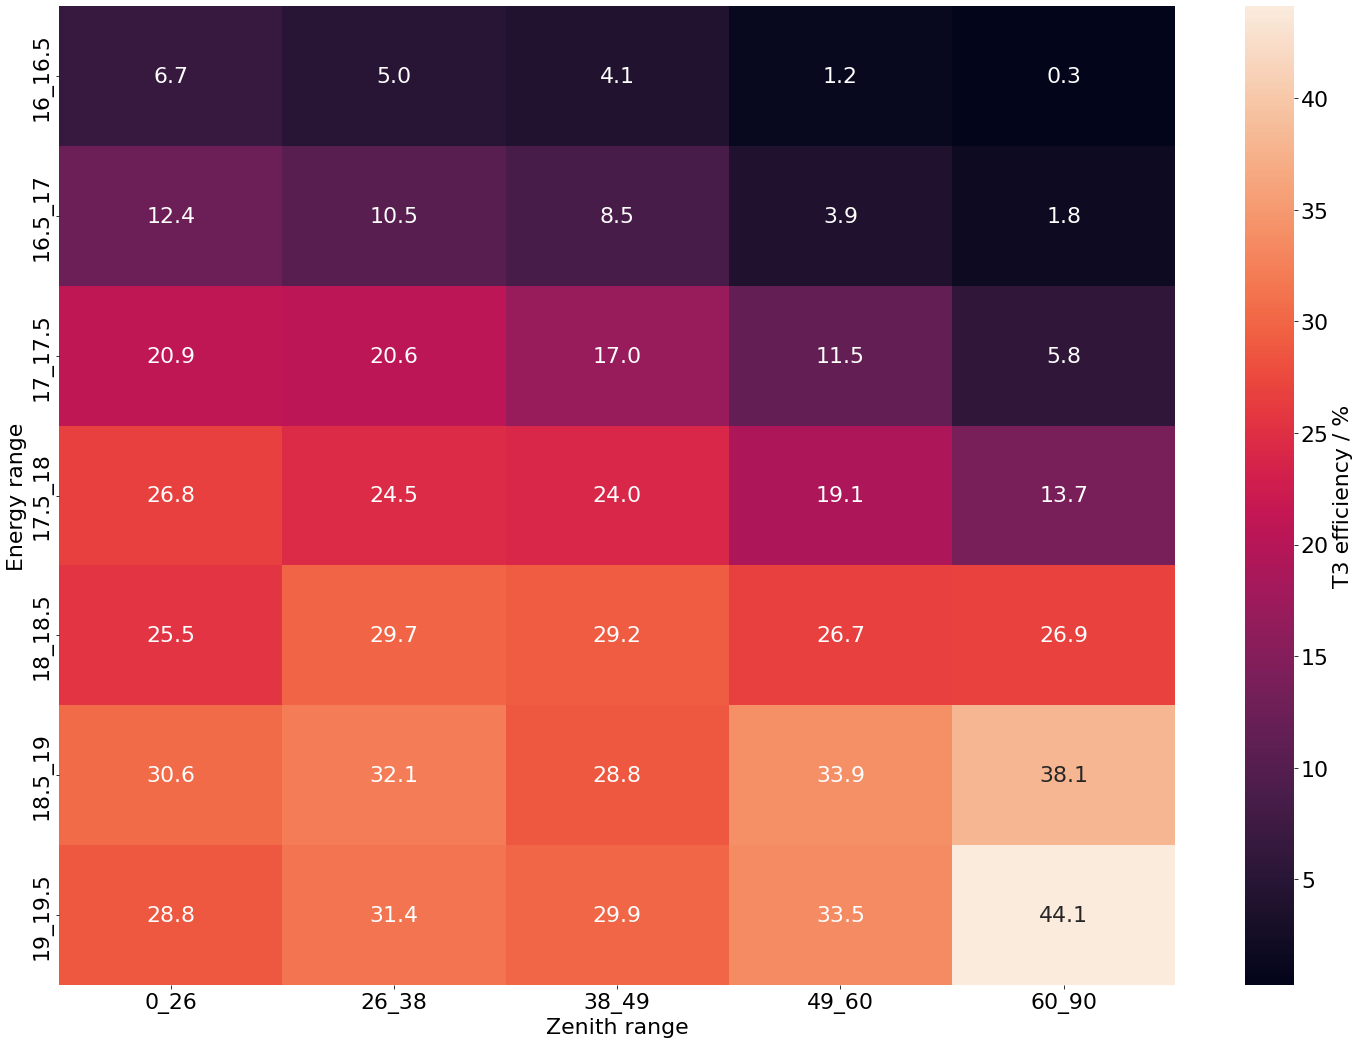

In [21]:
Hardware = HardwareClassifier()
do_t3_simulation(Hardware, "validation_data")